# Extract Data
We have a series of Raman and XRD measurements of our material as a function of temperature.
They are currently stored in different files in different formats.
In this notebook, we put them all in the same Pandas dataframe.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from zipfile import ZipFile
from io import BytesIO
import pandas as pd
import numpy as np
import os

## Load in the Experimental Procedure
Has the heating/cooling profile used and lists the order of the measurements

In [2]:
data = pd.read_excel(os.path.join('data', 'KOH85Nb2O5-6-organized', 'KOH85Nb2O5-6-temperature-log.xlsx'))
print(f'Log contains {len(data)} experiments')

Log contains 365 experiments


Assign an ID each measurements at each temperature

In [3]:
data['sub sequence'] = data.groupby('Name').cumcount()

## Load in the XRD patterns
Load in the data from a ZIP file and extract the contents

In [4]:
with ZipFile(os.path.join('data', 'KOH85Nb2O5-6-organized', 'XRD-xye.zip')) as xrd_zip:
    xrd_data = dict((os.path.basename(f.filename), xrd_zip.read(f.filename)) for f in xrd_zip.filelist if f.filename.endswith('.xye'))
print(f'Loaded {len(xrd_data)} XRD patterns')

Loaded 365 XRD patterns


Parse the contents

In [5]:
def parse_xye_contents(file_contents):
    """Get XRD pattern from an xye file
    
    Args:
        file_contents (bytes): Contents of the file
    Returns:
        (ndarray) XRD pattern where column 0 is the 2theta 
            and column 1 is the intensity
    """
    return np.loadtxt(BytesIO(file_contents), skiprows=3, usecols=(0, 1))

In [6]:
%%time
xrd_data = dict((k, parse_xye_contents(v)) for k, v in xrd_data.items())

Wall time: 8.06 s


Gather data for each column

In [7]:
%%time
data['xrd pattern'] = data[['Name', 'sub sequence']].apply(lambda x: f'{x["Name"]}-{x["sub sequence"]:05d}.xye', axis=1).apply(xrd_data.get)

Wall time: 20 ms


Make a plot of all the data

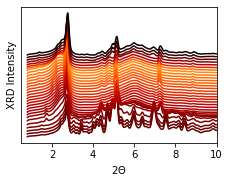

In [8]:
fig, ax = plt.subplots()

# Get a color map
cmap = plt.get_cmap('gist_heat')
min_temp = data['measured temp'].min()
max_temp = data['measured temp'].max()
color = lambda x: cmap(0.9 * (x - min_temp) / max_temp)

# Plot each graph
for rid, row in data.iterrows():
    if rid % 12 != 0: continue
    
    # Scale the XRD pattern from [0, 1]
    xrd_pattern = row['xrd pattern'].copy()
    xrd_pattern[:, 1] /= xrd_pattern[:, 1].max()
    
    ax.plot(xrd_pattern[:, 0], xrd_pattern[:, 1] + rid * 0.005, color=color(row['measured temp']))

ax.set_xlim([0.5, 10])
ax.set_yticks([])
ax.set_xlabel('$2\Theta$')
ax.set_ylabel('XRD Intensity')

fig.set_size_inches(3.5, 2.5)

## Load in the Raman Data
They are in csv format and also stored in a ZIP file.

In [9]:
with ZipFile(os.path.join('data', 'KOH85Nb2O5-6-organized', 'Raman-csv.zip')) as raman_zip:
    raman_data = dict((os.path.basename(f.filename), raman_zip.read(f.filename)) for f in raman_zip.filelist if f.filename.endswith('.csv'))
print(f'Loaded {len(raman_data)} Raman patterns')

Loaded 365 Raman patterns


In [10]:
%%time
raman_data = dict((k, pd.read_csv(BytesIO(v))) for k, v in raman_data.items())

Wall time: 679 ms


Add them to the data array

In [11]:
%%time
data['raman spectrum'] = data[['Name', 'sub sequence']].apply(lambda x: f'{x["Name"]}-{x["sub sequence"]:05d}.tif-raman.csv', axis=1).apply(raman_data.get)

Wall time: 14 ms


AttributeError: 'NoneType' object has no attribute 'copy'

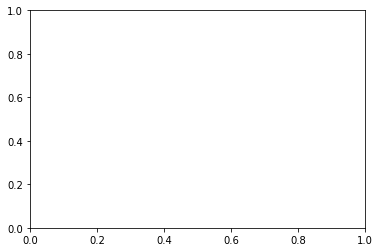

In [12]:
fig, ax = plt.subplots()

# Get a color map
cmap = plt.get_cmap('gist_heat')
min_temp = data['measured temp'].min()
max_temp = data['measured temp'].max()
color = lambda x: cmap(0.9 * (x - min_temp) / max_temp)

# Plot each graph
for rid, row in data.iterrows():
    if rid % 12 != 0: continue
    
    # Scale the spectrum from [0, 1]
    raman = row['raman spectrum'].copy()
    raman['Intensity'] -= raman['Intensity'].min()
    raman['Intensity'] /= raman['Intensity'].max()
    
    ax.plot(raman['Wavelength'], raman['Intensity'] + rid * 0.005, color=color(row['measured temp']))

#ax.set_xlim([0.5, 10])
ax.set_yticks([])
ax.set_xlabel('Wavelength')
ax.set_ylabel('Raman Intensity')

fig.set_size_inches(3.5, 2.5)

## Save Data
We're going to pickle format for convenience in loading it back in

In [ ]:
%%time
data.to_pickle('data.pkl.gz')